## Вариант 7. Панков Викентий

In [1]:
from scipy import stats
from scipy.stats._distn_infrastructure import rv_frozen
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from typing import List, Tuple, Callable

from skgof import ks_test, cvm_test
from skgof.ecdfgof import GofResult

## 0. Проверим корректность тестов, которые будут использоваться далее

In [3]:
# Построим ошибку первого и второго рода для разных n с моделированием выборок из нормального распределения
# test_id: 0 - Колмогорова-Смирнова, 1 - w^2, 2 - тест Уэлча

def CheckTest(test_id: int):
    Ns = [10, 50, 100, 150, 200, 250, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1500, 1800, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000, 7000, 8000, 9000, 10000]

    alpha = 0.05


    h0ErrFromN = []
    h1ErrFromN = []

    for n in Ns:
        h0_errors = 0
        h1_errors = 0
        for it in range(0,2000):
            sample1 = stats.norm.rvs(1, 1, n)
            sample2 = stats.norm.rvs(1.4, 1.3, n)

            if(test_id == 0):
                if(ks_test(sample1, stats.norm(1,1)).pvalue < alpha):
                    h0_errors +=1

                if(ks_test(sample2, stats.norm(1,1)).pvalue > alpha):
                    h1_errors +=1

            elif(test_id == 1):
                if(cvm_test(sample1, stats.norm(1,1)).pvalue < alpha):
                    h0_errors +=1

                if(cvm_test(sample2, stats.norm(1,1)).pvalue > alpha):
                    h1_errors +=1

            elif(test_id == 2):
                sample3 = stats.norm.rvs(1, 1, n)
                if(stats.ttest_ind(sample1, sample3, equal_var=False).pvalue < alpha):
                    h0_errors +=1

                if(stats.ttest_ind(sample2, sample3, equal_var=False).pvalue > alpha):
                    h1_errors +=1

        h0ErrFromN.append(h0_errors/2000)
        h1ErrFromN.append(h1_errors/2000)

    plt.plot(Ns, h0ErrFromN)
    plt.title("Ошибка первого рода")
    plt.xlabel("Размер выборки")
    plt.ylabel("Ошибка")


    plt.figure()
    plt.plot(Ns, h1ErrFromN)
    plt.title("Ошибка второго рода")
    plt.xlabel("Размер выборки")
    plt.ylabel("Ошибка")

### Тест Колмогорова-Смирнова:

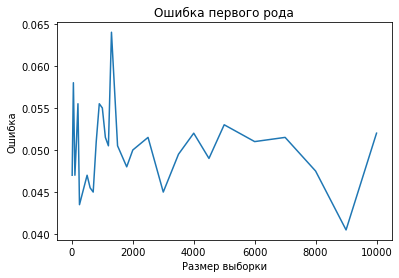

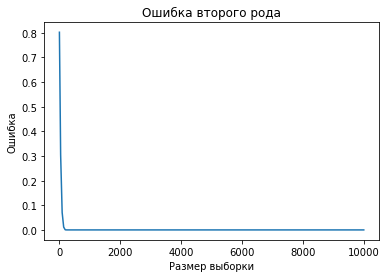

In [4]:
CheckTest(0)

### Тест $\omega^2$:

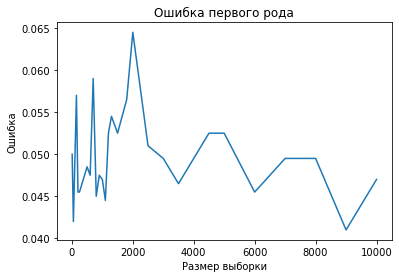

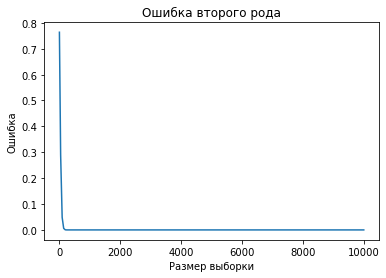

In [5]:
CheckTest(1)

### t-test Уэлча:

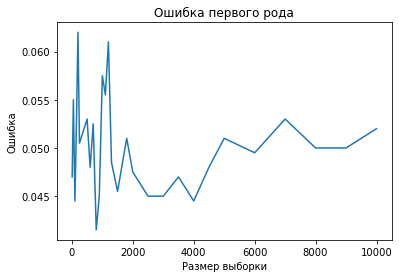

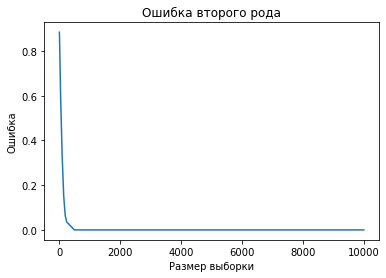

In [7]:
CheckTest(2)

** Все тесты состоятельны и имеют заданный асимптотический размер **

## 1. $H_0: a = a_0$ против $H_1: a \neq a_0 = a_1$ для параметра сдвига gamma-распределения

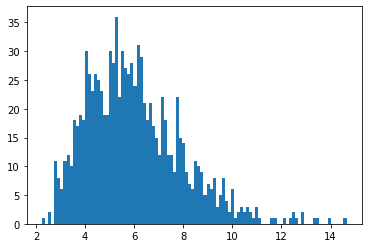

In [74]:
gammaLoc = 2
gammaShape = 4
r = stats.gamma.rvs(a = gammaShape, loc = gammaLoc, size=1000)
h = plt.hist(r, bins=100)

In [171]:
def getPower(n: int, a0: float, a1: float, test: Callable[[float, rv_frozen], GofResult]) -> float:
    alpha: float = 0.05
    goods: float = 0
    iter_count: int = 100

    for i in range(0, iter_count):
        r = stats.gamma.rvs(a = gammaShape, loc = a0, size=n)
        res: GofResult = test(r, stats.gamma(gammaShape, a1))
        goods += (res.pvalue < alpha)

    return goods / iter_count

In [176]:
print("Cramér–von Mises test: ",getPower(200, gammaLoc, gammaLoc + 0.5, cvm_test))
print("Kolmogorov–Smirnov test: ", getPower(200, gammaLoc, gammaLoc + 0.5, ks_test))

Cramér–von Mises test:  0.93
Kolmogorov–Smirnov test:  0.9


### Построим зависимость мощности от размера выборки

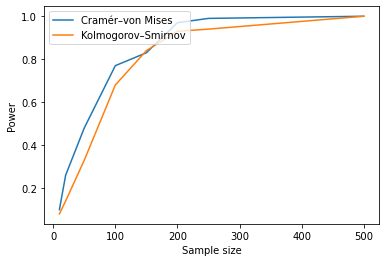

In [129]:
Ns: List[int]  = [10, 20, 50, 100, 150, 200, 250, 500]
ksPowers: List[float] = list(map(lambda x: getPower(x, gammaLoc, ks_test), Ns))
cvmPowers: List[float] = list(map(lambda x: getPower(x, gammaLoc, cvm_test), Ns))
plt.plot(Ns, cvmPowers, label="Cramér–von Mises")
plt.plot(Ns, ksPowers, label="Kolmogorov–Smirnov")
plt.legend(loc='upper left')
plt.xlabel("Sample size")
plt.ylabel("Power")
pass

### Построим зависимость мощности от разности между $a_1$ и $a_0$ при $n = 100$

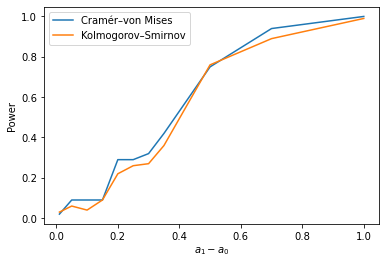

In [184]:
a1: List[int]  = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5, 0.7, 1]
ksPowers: List[float] = list(map(lambda x: getPower(100, gammaLoc, gammaLoc + x, ks_test), a1))
cvmPowers: List[float] = list(map(lambda x: getPower(100, gammaLoc, gammaLoc + x, cvm_test), a1))
plt.plot(a1, cvmPowers, label="Cramér–von Mises")
plt.plot(a1, ksPowers, label="Kolmogorov–Smirnov")
plt.legend(loc='upper left')
plt.xlabel("$a_1 - a_0$")
plt.ylabel("Power")
pass

**Более мощным оказался $\omega^2$**

## 2. Анализ датасета

### Attribute Information.
  1.  Sequence Name: Accession number for the SWISS-PROT database
  2.  mcg: McGeoch's method for signal sequence recognition.
  3.  gvh: von Heijne's method for signal sequence recognition.
  4.  alm: Score of the ALOM membrane spanning region prediction program.
  5.  mit: Score of discriminant analysis of the amino acid content of
	   the N-terminal region (20 residues long) of mitochondrial and 
           non-mitochondrial proteins.
  6.  erl: Presence of "HDEL" substring (thought to act as a signal for
	   retention in the endoplasmic reticulum lumen). Binary attribute.
  7.  pox: Peroxisomal targeting signal in the C-terminus.
  8.  vac: Score of discriminant analysis of the amino acid content of
           vacuolar and extracellular proteins.
  9.  nuc: Score of discriminant analysis of nuclear localization signals
	   of nuclear and non-nuclear proteins.

In [167]:
data = pd.read_csv("yeast.data", sep="\t")
data

,accession_number,mcg,gvh,alm,mit,erl,pox,vac,nuc,loc
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...,...
1479,YUR1_YEAST,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,ME2
1480,ZIP1_YEAST,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,ZNRP_YEAST,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,ME2
1482,ZUO1_YEAST,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


### Посмотрим на выборочные средние по группам:



In [14]:
data.groupby("loc").mean()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
loc,,,,,,,,
CYT,0.480713,0.469503,0.535421,0.227106,0.504320,0.001080,0.499395,0.257235
ERL,0.792000,0.772000,0.482000,0.336000,1.000000,0.000000,0.546000,0.246000
EXC,0.735429,0.716857,0.492571,0.292000,0.500000,0.000000,0.455714,0.226571
ME1,0.788636,0.756591,0.376136,0.311818,0.500000,0.000000,0.512955,0.268182
ME2,0.721569,0.603137,0.414902,0.282549,0.509804,0.000000,0.510196,0.245490
ME3,0.430859,0.489509,0.364294,0.213497,0.503067,0.000000,0.510123,0.270000
MIT,0.521434,0.533238,0.517377,0.404426,0.500000,0.008852,0.501680,0.240984
NUC,0.452448,0.456131,0.529324,0.228345,0.503497,0.000000,0.494103,0.331678
POX,0.521000,0.508000,0.506500,0.247500,0.500000,0.423500,0.503000,0.234000


** Выдвинем гипотезу: ** в группе белков, локализирующихся в ядре, значение оценки дискриминантного анализа сигналов ядерной локализации белков (**nuc**), больше, чем в группе белков, локализирующихся в цитоплазме  

$H_0$: $\mu_{nuc} = \mu_{cyt}$  $H_1$: $\mu_{nuc} > \mu_{cyt}$  

Проверим гипотезу на уровне значимости $\alpha = 0.01$



In [162]:
nuc_df = data[data["loc"]=="NUC"].nuc
cyt_df = data[data["loc"]=="CYT"].nuc

Применим Welch t-test, предполагая неравенство дисперсий:

In [164]:
stats.ttest_ind(nuc_df, cyt_df, axis=0, equal_var=False)


Ttest_indResult(statistic=9.407456345070102, pvalue=5.907259707328323e-20)

$pvalue/2 < 0.01$. Есть основания отвергнуть $H_0$ и считать, что в группе белков из ядра, показатель **nuc** больше, чем в группе белков из цитоплазмы